# **IMPORT LIBRARY**

In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.utils import plot_model
from keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")

2024-06-01 11:47:37.798487: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-01 11:47:37.798591: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-01 11:47:38.056391: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **VISUALISASI IMAGES**

i. Load images

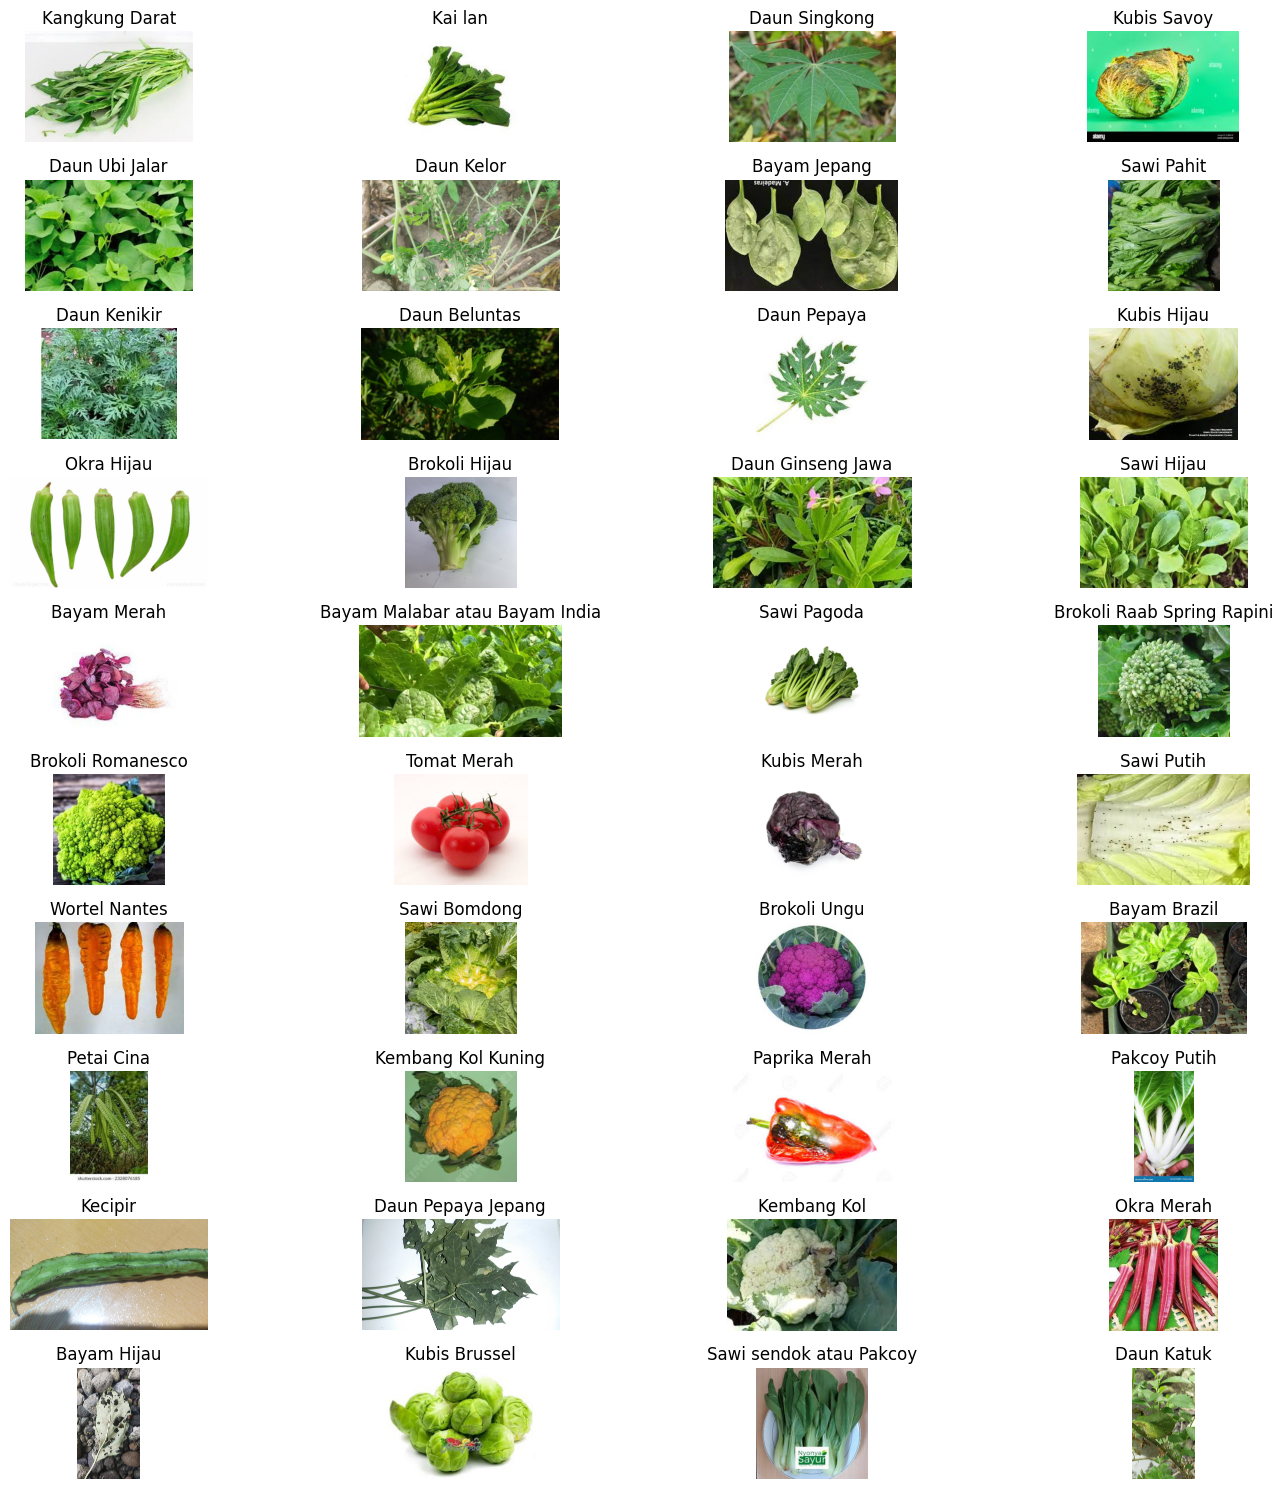

In [2]:
train_path = '/kaggle/input/vegetables-names-images/Vegetables/train'
class_names = [name for name in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, name))]

# Function untuk load and menampilkan image dengan label (mnenggunakan error handling)
def display_image(path, label):
    try:
        # Read image menggunakan OpenCV
        img = cv2.imread(path)
        if img is None:
            raise Exception(f"Error reading image: {path}")  
        # Convert ke RGB format
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img
    except Exception as e:
        print(f"Error processing image: {path} ({e})")
        return None  

# Calculate nomor dari baris yang dibutuhkan di grid
num_classes = len(class_names)
num_cols = 4
num_rows = (num_classes + num_cols - 1) // num_cols  # Ceiling division to ensure all classes fit

# Create figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))  # Adjust figsize for better visualization

# Display one image for each class
for idx, class_name in enumerate(class_names):
    class_path = os.path.join(train_path, class_name)
    images = []
    
    # Collect images from subfolders, if present
    subfolders = [subfolder for subfolder in os.listdir(class_path) if os.path.isdir(os.path.join(class_path, subfolder))]
    if subfolders:
        for subfolder in subfolders:
            subfolder_path = os.path.join(class_path, subfolder)
            images.extend([os.path.join(subfolder_path, img) for img in os.listdir(subfolder_path) if img.endswith(('jpg', 'png', 'jpeg'))])
    else:
        # Collect images directly from class folder if no subfolders
        images.extend([os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith(('jpg', 'png', 'jpeg'))])

    if images:
        image_path = random.choice(images)  # Randomly select one image
        img = display_image(image_path, class_name)
        ax = axes[idx // num_cols, idx % num_cols]
        if img is not None:  # Check jika image telah berhasil terload 
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(class_name)
        else:
            ax.text(0.5, 0.5, "Error", ha='center', va='center', color='red')
            ax.axis('off')
    else:
        ax = axes[idx // num_cols, idx % num_cols]
        ax.text(0.5, 0.5, "No images", ha='center', va='center', color='red')
        ax.axis('off')

# Hide any empty subplots
for i in range(num_classes, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

# Adjust layout and display figure
fig.tight_layout()
plt.show()


ii. check bad images

In [3]:
train_path = '/kaggle/input/vegetables-names-images/Vegetables/train'
val_path = '/kaggle/input/vegetables-names-images/Vegetables/validation'
test_path = '/kaggle/input/vegetables-names-images/Vegetables/test'

In [4]:
def check_images(path):
    for subdir, dirs, files in os.walk(path):
        for file in files:
            file_path = os.path.join(subdir, file)
            try:
                img = Image.open(file_path) # buka iamge file
                img.verify() # memverifikasi image
            except (IOError, SyntaxError) as e:
                print('Bad file:', file_path)

check_images(train_path)
check_images(val_path)
check_images(test_path)

# **PREPARE DATASET CATEGORICAL**

> Load the training dataset with generator and use augmentation

In [5]:
train_generator = ImageDataGenerator(
    rescale=1.0/255, # scalling image 0<=x<=1
    width_shift_range=0.2,          # Shift images horizontally by up to 20% of their width
    height_shift_range=0.2,         # Shift images vertically by up to 20% of their width
    rotation_range=40, # 40 derajat
    shear_range=0.2, # shear(penggeseran) images by 10% their size
    zoom_range=0.2,# Zoom in and out images by 10%
    fill_mode='nearest', # fill unlocated pixels by nearest pixel (Fills the empty pixels with the nearest pixel value from the valid part of the image.)
    horizontal_flip=True, # Allow horizontal flipping
)

train_image_generator = train_generator.flow_from_directory(
    train_path, # Target path data
    target_size=(224, 224),  # Resize images 
    shuffle=True,
    color_mode='rgb', 
    class_mode='categorical', # type model
    batch_size=32
)

Found 6241 images belonging to 40 classes.


> Load the validation dataset with generator and use augmentation

In [6]:
val_generator = ImageDataGenerator(rescale=1.0/255)
val_image_generator = val_generator.flow_from_directory(
    val_path, 
    target_size=(224, 224), 
    shuffle=False,
    color_mode='rgb',
    class_mode='categorical', 
    batch_size=32
)

Found 1325 images belonging to 40 classes.


In [7]:
# Print the class encodings done by the generators
class_map = dict([(v, k) for k, v in train_image_generator.class_indices.items()])
for key, value in class_map.items():
    print(f"{key} : {value}")

0 : Bayam Brazil
1 : Bayam Hijau
2 : Bayam Jepang
3 : Bayam Malabar atau Bayam India
4 : Bayam Merah
5 : Brokoli Hijau
6 : Brokoli Raab Spring Rapini
7 : Brokoli Romanesco
8 : Brokoli Ungu
9 : Daun Beluntas
10 : Daun Ginseng Jawa
11 : Daun Katuk
12 : Daun Kenikir
13 : Daun Pepaya
14 : Daun Pepaya Jepang
15 : Daun Singkong
16 : Daun Ubi Jalar
17 : Daun Kelor
18 : Kai lan
19 : Kangkung Darat
20 : Kecipir
21 : Kembang Kol
22 : Kembang Kol Kuning
23 : Kubis Brussel
24 : Kubis Hijau
25 : Kubis Merah
26 : Kubis Savoy
27 : Okra Hijau
28 : Okra Merah
29 : Pakcoy Putih
30 : Paprika Merah
31 : Petai Cina
32 : Sawi Bomdong
33 : Sawi Hijau
34 : Sawi Pagoda
35 : Sawi Pahit
36 : Sawi Putih
37 : Sawi sendok atau Pakcoy
38 : Tomat Merah
39 : Wortel Nantes


# **BUILD CNN MODEL CATEGORYCAL**

i. build model

- firts try 128, 64, 32 with hidden layer unit 1024 the result is overviting (no augmentation) --> acc naik pesat, val_acc naik+turun, loss turun pesat, va_lost naik pesat
- second try 128, 64, 32 with hidden layer unit 1024 the result is underfiting (with augmentation) --> acc naik perlahan, val_acc naik perlahan, loss turun perlahan, val_loss turun perlahan
- third try 128, 64, 32 with hidden layer unit 1024 the result is underfiting (use Batch Normalization = meningkatkan kecepatan dan stabilitas pelatihan jaringan saraf tiruan) --> acc lebih tinggi, val_acc naik tapi sedikit, loss turun, val_loss turun tapi masih besar
- fourth try 128, 64, 32 with hidden layer 512 the result is 0vervitting (with augmentation) --> loss down, val_loss up, acc up, val_acc down
- 

- semakin besar filter dan units maka bisa meningkatkan overfitting jika data tidak cukup besar dan bervariasi

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1, 1), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1, 1), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    tf.keras.layers.Flatten(), # Flatten the output layer to 1 dimension
    tf.keras.layers.Dense(units=256, activation='relu'), 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=40, activation='softmax')
])

ii. model diagram

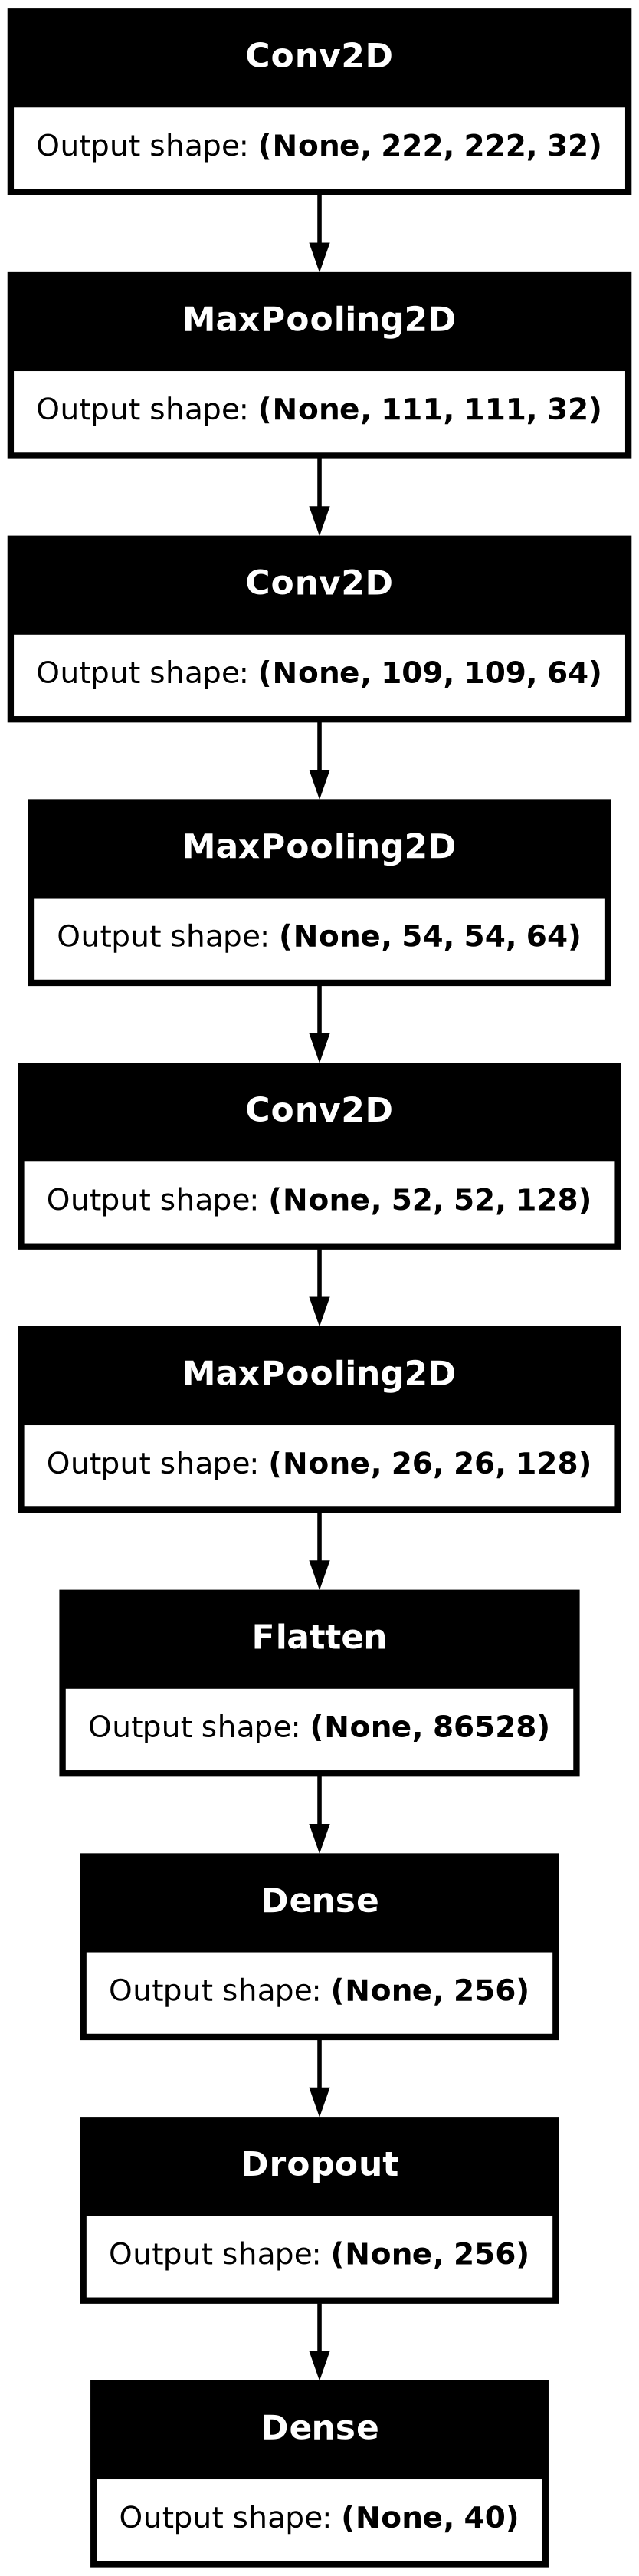

In [9]:
plot_model(model, show_shapes=True, show_layer_names=False, dpi=200)

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 40)             │        10,280 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,254,952 (84.90 MB)

 Trainable params: 22,254,952 (84.90 MB)

 Non-trainable params: 0 (0.00 B)

iii. compile model

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

iv. training model

In [ ]:
history = model.fit(train_image_generator, epochs=50, validation_data=val_image_generator, verbose=1)

Epoch 1/50
  2/196 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.0312 - loss: 4.6302 

I0000 00:00:1717242563.986465     131 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717242564.005698     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 720ms/step - accuracy: 0.0643 - loss: 3.6492

W0000 00:00:1717242705.190687     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


196/196 ━━━━━━━━━━━━━━━━━━━━ 177s 817ms/step - accuracy: 0.0645 - loss: 3.6467 - val_accuracy: 0.1404 - val_loss: 3.0605
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 144s 711ms/step - accuracy: 0.1314 - loss: 3.1018 - val_accuracy: 0.1940 - val_loss: 2.8316
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 143s 709ms/step - accuracy: 0.1666 - loss: 2.9508 - val_accuracy: 0.2204 - val_loss: 2.7196
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 143s 703ms/step - accuracy: 0.1870 - loss: 2.8298 - val_accuracy: 0.2377 - val_loss: 2.6497
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 142s 703ms/step - accuracy: 0.2171 - loss: 2.7260 - val_accuracy: 0.2679 - val_loss: 2.5264
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 145s 715ms/step - accuracy: 0.2191 - loss: 2.7205 - val_accuracy: 0.2958 - val_loss: 2.4625
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 145s 714ms/step - accuracy: 0.2400 - loss: 2.6381 - val_accuracy: 0.2581 - val_loss: 2.5733
Epoch 8/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 144s 713ms/step - accuracy: 0.2558 - loss: 2.58

# **PLOT RESULT DATA TRAINING**

In [ ]:
result_data = pd.DataFrame(history.history)
result_data.head()

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# learning_rate = history.history['lr']

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Accuracy vs Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].set_title('Loss vs Epochs')
ax[1].plot(loss, 'o-', label='Train loss')
ax[1].plot(val_loss, 'o-', label='Validation loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

# ax[2].set_title('Learning rate vs epoch')
# ax[2].plot(learning_rate, ls='o-', label='Learning rate')
# ax[2].set_xlabel('Epochs')
# ax[2].set_ylabel('Learning rate')
# ax[2].legend()

plt.tight_layout()
plt.show()

# **TEST MODEL**

In [ ]:
test_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = test_generator.flow_from_directory(
    test_path,
    target_size=(224, 224),
    shuffle=False,
    batch_size=32,
    class_mode='categorical'
)

In [ ]:
predictions = model.predict(test_image_generator)

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0
for i in range(2):
    for j in range(5):
        prediction_class = class_map[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{prediction_class}")
        ax[i, j].imshow(test_image_generator[0][0][idx])
        idx += 1

plt.suptitle('Prediction Testing', fontsize=20)
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_image_generator, batch_size = 32)

In [ ]:
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy} -> {100*test_accuracy:.2f}%")

# **PLOT TEST MODEL**

i. define y_hat(prediction) and y

In [ ]:
y_hat = np.argmax(predictions, axis=1)
y_true = test_image_generator.classes

In [ ]:
cf_mtx = confusion_matrix(y_true, y_hat)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_class = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_class = np.asarray(box_class).reshape(40,40)

plt.figure(figsize = (40, 35))
sns.heatmap(cf_mtx, xticklabels=class_map.values(), yticklabels=class_map.values(),
           cmap="YlGnBu", fmt="", annot=box_class)
plt.xlabel('Predicted Classes', fontsize=20)
plt.ylabel('True Classes', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
print(classification_report(y_true, y_hat, target_names=class_map.values()))

# **WRONG PREDICTION**

In [ ]:
errors = (y_true - y_hat != 0)
y_true_errors = y_true[errors]
y_hat_errors = y_hat[errors]

In [ ]:
test_images = test_image_generator.filenames
# print(test_images)
test_img = np.asarray(test_images)[errors]
# print(test_img)

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20, 15))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_class = class_map[true_index]
        
        predicted_index = y_hat_errors[idx]
        predicted_class = class_map[predicted_index]
        
        ax[i, j].set_title(f"True Label: {true_class} \n Predicted Label: {predicted_class}")
        img_path = os.path.join(test_path, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
#         ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions test', fontsize=20)
plt.show()